In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tools import Agent, plot_values_lake, policy_improvement, discount_cumsum
env = gym.make('NChain-v0')

In [2]:
class MyRandomAgent(Agent):
    def __init__(self, env, is_deterministic = False):
        super().__init__(env)
        self.policy = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.is_deterministic = is_deterministic
    def act(self, state):
        if self.is_deterministic:
            action = np.argmax(self.policy[state])
        else:
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])
        return action

# Monte-Carlo Methods

Now, considering an environment without knowing its transition model, we want to build a smart agent, a free model based agent.
The naive approach is to estimate the Q function using monte-carlo estimation.
As we know:
\begin{aligned}
V_{\pi}(s) &= \mathbb{E}[G_t \vert S_t = s] = \frac{1}{P(S_t=s)}E[G_t \mathbb{1}_{S_t=s}] \\
Q_{\pi}(s, a) &= \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]
\end{aligned}
We compute the empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$, following policy $\pi$.
From law of large numbers the estimators:
\begin{aligned}
V_{\pi}(s) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s]}\\
Q(s, a) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a]}
\end{aligned}



[
$\frac{\sum_{i=1}^n \mathbb{1}[S_i = s] G_i}{\sum_{i=1}^n \mathbb{1}[S_i = s]} $
is convergent if $G_{s_i}$ is Independent and identically distributed.
]


remember Incremental mean:
\begin{aligned}
\mu_K &= \frac{1}{K}\sum_{j=1}^K X_j\\
\mu_K &= \frac{1}{K}[X_K + \sum_{j=1}^{K-1} X_j]\\
\mu_K &= \frac{1}{K}[X_K + (K-1)\mu_{K-1}]\\
\mu_K &= \mu_{K-1} + \frac{1}{K}(X_K -\mu_{K-1})\\
\end{aligned}
We do the same to update incrementally at each episode the empirical $V$. For each state $S_t$ with return $G_t$:
\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \frac{1}{N(S_t)}(G_t -V(S_t))\\
\end{aligned}

In [3]:
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=10):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        episode = []
        
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            count_states[current_state] += 1
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(count_states):
            if count >0 :
                V[state] += (discount_empirical_return[episode[:,0] == state].sum() - V[state]) / count
        count_states = np.zeros(env.observation_space.n)
        episode = []
    return V

In [4]:
rand_agent = MyRandomAgent(env)
V = policy_MC_evaluation(env, rand_agent)

In [5]:
V #todo plot

array([6581.57338039, 6564.96894041, 6472.13736875, 6118.16787217,
       6294.66440709])

In [6]:
def get_epsilon_greedy_policy(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In the same way, we estimate the Q function. Ans we build an agent, improving its policy by acting greddy.
$\forall s$ $\pi'(.|s) = \arg\max_a Q_\pi(s,a)$.

In [7]:
class MyMCAgent(Agent):
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .1):
        super().__init__(env, is_deterministic, gamma, epsilon)
        self.q = np.zeros([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.count_state_actions = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.episode = []
    def update_policy_epsilon_greedy(self):
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)
    def train(self, current_state, action, reward, next_state, done):
        if done is False:
            self.episode.append(np.array([current_state, action, reward]))
            self.count_state_actions[current_state, action] += 1
        else:
            episode = np.asarray(self.episode)
            discount_empirical_return = discount_cumsum(episode[:,2], self.gamma)
            for state in range(len(self.count_state_actions)):
                for action, count in enumerate(self.count_state_actions[state]):
                    if count > 0 :
                        self.q[state,action] += (discount_empirical_return[(episode[:,0] == state) & (episode[:,1] == action)].sum() - self.q[state,action]) / count
            self.count_state_actions = np.zeros((self.env.observation_space.n, self.env.action_space.n))
            self.episode = []
            self.update_policy_epsilon_greedy()

In [8]:
def run_experiment_episode_train(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            agent.train(current_state, action, reward, state, done)
            rews.append(reward)
        rewards[i] = sum(rews)
    return rewards

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

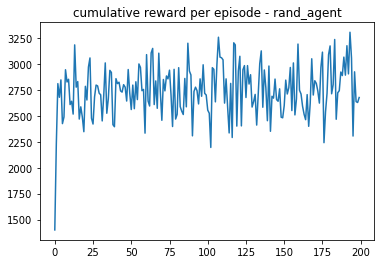

In [9]:
mc_agent = MyMCAgent(env)
rewards = run_experiment_episode_train(env, mc_agent, 200)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [10]:
mc_agent.policy

array([[0.05, 0.95],
       [0.95, 0.05],
       [0.95, 0.05],
       [0.95, 0.05],
       [0.95, 0.05]])

# Temporal-Difference-Learning

Using monte-carlo, we update $V(S_t)$ in that way

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_t)) \\
\end{aligned}
We also know (bellman equation) $\mathbb{E}[G_t|S_t=s] = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})|S_t=s]$. That pushes new estimators/update

target $= R_{t+1} + \gamma V(S_{t+1}$

error $=$ target $- V(S_t)$

update:  

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}

In [11]:
def policy_td_evaluation(env, agent, gamma=1, nb_episode=10, alpha = .001):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[state]
            V[current_state] += alpha * td_error
    return V

In [12]:
rand_agent = MyRandomAgent(env)
V = policy_MC_evaluation(env, rand_agent)
V

array([6516.55181063, 6296.41247672, 6084.76292527, 6038.35176292,
       6089.11729764])

### SARSA

Same principle for q function update using Temporal difference$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$.

In [13]:
class MySarsaAgent(Agent):
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, is_deterministic, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.previous_state = None
        self.previous_action = None
        self.reward = None
    def qsa_update(self, state, next_state, reward, action, next_action): 
        if state is None:
            #no update for first step
            return
        elif next_state is not None:
            target = reward + self.gamma * self.q[next_state, next_action] 
        else:
            target = reward
        td_error = target - self.q[state, action]
        self.q[state, action]  += self.alpha * td_error
    def update_policy_epsilon_greedy(self):
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)
    def train(self, current_state, action, reward, next_state, done):
        if done is False:
            self.qsa_update(self.previous_state, current_state, self.reward, self.previous_action, action)
            self.previous_state = current_state
            self.previous_action = action
            self.reward = reward
        else:
            self.qsa_update(self.previous_state, None, self.reward, self.previous_action, None)
            self.previous_state = None
            self.previous_action = None
            self.reward = None
        self.update_policy_epsilon_greedy()

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

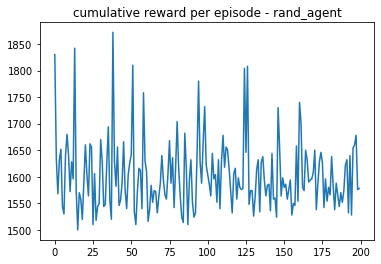

In [14]:
sarsa_agent = MySarsaAgent(env)
rewards = run_experiment_episode_train(env, sarsa_agent, 200)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [15]:
sarsa_agent.policy

array([[0.05, 0.95],
       [0.05, 0.95],
       [0.05, 0.95],
       [0.05, 0.95],
       [0.95, 0.05]])

### Q-learning

Q learning is an offpolicy sarsa. Instead of update the Q function with the current policy action, it uses a greedy estimation of the policy action

SARAS $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$

Q-learning $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

In [16]:
class MyQAgent(Agent):
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, is_deterministic, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        if done is False:
            target = reward + self.gamma * np.max(self.q[next_state, :])
        else:
            target = reward
        td_error = target - self.q[state, action]
        self.q[state, action]  += self.alpha * td_error
    def update_policy_epsilon_greedy(self):
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        self.update_policy_epsilon_greedy()

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

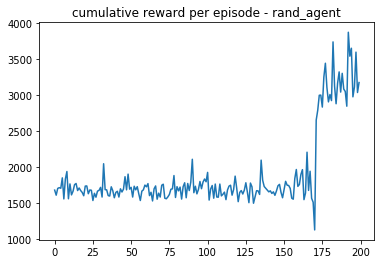

In [17]:
q_agent = MyQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 200)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [18]:
q_agent.policy

array([[0.95, 0.05],
       [0.95, 0.05],
       [0.95, 0.05],
       [0.95, 0.05],
       [0.95, 0.05]])

### keep in mind:
\begin{aligned}
MDP \rightarrow V(S_t) &\leftarrow \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})] \\
MC \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_{t+1})\\
TD \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}